# Feature types de novo models under-utilize

When rescoring spectra with ms2rescore, the match is explained by interpretable features. These features include the number of peaks matched (hyperscore), the intensity matched, how well the pattern of ion intensities corroborate with what we expect to see, ion mobility and retention times. This orthogonal information is brought together into a single score, the ms2rescore score. Here, we will look which features are responsible for lower-scoring de novo PSMs.

In [1]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

from denovo_utils.io.read import load_psmlist, load_features

from Levenshtein import editops # To track actions for transpositions
from nltk import edit_distance # For Damerau–Levenshtein distance

import numpy as np
import pandas as pd

2025-01-26 23:15:28.725335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 23:15:28.741005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 23:15:28.745653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


# 1. Load the data

In [2]:
root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/rescoring'
root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'
run_names = [
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

engine_names = [
    'adanovo',
    'pihelixnovo',
    'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

runs = {}
for run_name in run_names:
    print(f"Run: {run_name}")
    run = Run(run_name)

    mgf_path = os.path.join(root_mgf, run_name + '.mgf')

    # Load a ground-truth
    psmlist_gt = load_psmlist(os.path.join(
        root_results_dn, run_name, 'psmlist', 'ground_truth.parquet'
    ))
    # parser = DenovoEngineConverter.select('sage')
    # psmlist_gt = parser.parse(
    #     result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
    #     mgf_path=mgf_path
    # )
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=['score_ms2rescore'],
        is_ground_truth=True
    )

    # Load the de novo results
    for engine_name in engine_names:
        print(f'loading {engine_name}')
        dn_path = os.path.join(root_results_dn, run_name, 'psmlist', engine_name + '.parquet')
        
        psmlist_denovo = load_psmlist(psm_path=dn_path)
        
        # parser = DenovoEngineConverter.select(engine_name)
        # psmlist_denovo = parser.parse(
        #     result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
        #     mgf_path=mgf_path
        # )
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=['score_ms2rescore'],
            is_ground_truth=False
        )
    
    runs[run_name] = run


for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        gt_score = spectrum.psm_gt.scores.get_score('sage')
        spectrum.psm_gt.scores.add_score(
            score=gt_score,
            metadata='score_ms2rescore',
            score_type='peptide'
        )
        spectrum.compare_gt(
            'score_ms2rescore',
            ignore_score=False
        )

Run: LFQ_Orbitrap_DDA_Ecoli_01


100%|██████████| 24285/24285 [00:00<00:00, 33009.81it/s]


loading adanovo


100%|██████████| 61843/61843 [00:00<00:00, 121871.71it/s]


loading pihelixnovo


100%|██████████| 61955/61955 [00:00<00:00, 134099.48it/s]


loading piprimenovo


100%|██████████| 58682/58682 [00:00<00:00, 140578.88it/s]


loading casanovo


100%|██████████| 61876/61876 [00:00<00:00, 127480.83it/s]


loading instanovo


100%|██████████| 61562/61562 [00:00<00:00, 140839.25it/s]


loading contranovo


100%|██████████| 30999/30999 [00:00<00:00, 123972.71it/s]


loading novob


100%|██████████| 61479/61479 [00:00<00:00, 132207.64it/s]


loading pepnet


100%|██████████| 62560/62560 [00:02<00:00, 21878.30it/s] 


Run: LFQ_Orbitrap_DDA_Human_01


100%|██████████| 90817/90817 [00:06<00:00, 14399.22it/s]


loading adanovo


100%|██████████| 115178/115178 [00:01<00:00, 63362.52it/s]


loading pihelixnovo


100%|██████████| 115417/115417 [00:08<00:00, 14260.95it/s]


loading piprimenovo


100%|██████████| 111287/111287 [00:01<00:00, 63870.56it/s]


loading casanovo


100%|██████████| 115362/115362 [00:01<00:00, 61639.97it/s]


loading instanovo


100%|██████████| 114725/114725 [00:01<00:00, 63294.63it/s]


loading contranovo


100%|██████████| 57640/57640 [00:01<00:00, 56784.93it/s]


loading novob


100%|██████████| 114064/114064 [00:01<00:00, 65753.49it/s]


loading pepnet


100%|██████████| 118245/118245 [00:01<00:00, 68821.11it/s]


Run: LFQ_Orbitrap_DDA_QC_01


100%|██████████| 83941/83941 [00:01<00:00, 55741.30it/s]


loading adanovo


100%|██████████| 107088/107088 [00:01<00:00, 66593.34it/s]


loading pihelixnovo


100%|██████████| 107182/107182 [00:01<00:00, 62947.95it/s]


loading piprimenovo


100%|██████████| 103511/103511 [00:01<00:00, 66095.72it/s]


loading casanovo


100%|██████████| 107203/107203 [00:01<00:00, 60555.58it/s]


loading instanovo


100%|██████████| 106604/106604 [00:01<00:00, 67616.42it/s]


loading contranovo


100%|██████████| 53533/53533 [00:00<00:00, 59885.08it/s]


loading novob


100%|██████████| 106075/106075 [00:01<00:00, 67036.11it/s]


loading pepnet


100%|██████████| 109340/109340 [00:01<00:00, 69397.91it/s]


Run: LFQ_Orbitrap_DDA_Yeast_01


100%|██████████| 67111/67111 [00:01<00:00, 63307.87it/s]


loading adanovo


100%|██████████| 102427/102427 [00:01<00:00, 88866.72it/s]


loading pihelixnovo


100%|██████████| 102483/102483 [00:01<00:00, 85000.04it/s]


loading piprimenovo


100%|██████████| 96975/96975 [00:01<00:00, 83776.26it/s] 


loading casanovo


100%|██████████| 102518/102518 [00:01<00:00, 84606.79it/s]


loading instanovo


100%|██████████| 101883/101883 [00:01<00:00, 88647.06it/s]


loading contranovo


100%|██████████| 51215/51215 [00:00<00:00, 76994.09it/s]


loading novob


100%|██████████| 101183/101183 [00:01<00:00, 86707.11it/s]


loading pepnet


100%|██████████| 43131/43131 [00:29<00:00, 1485.88it/s]


# 2. Create 3 groups

Higher and lower scoring ones in a given range, and those that are very similar.

In [10]:
score_table = []

denovo_order = [
    'pi-PrimeNovo',
    'pi-HelixNovo',
    'AdaNovo',
    'instanovo',
    'novob',
    'casanovo',
    'contranovo',
    'pepnet'
]

for run_name, run in runs.items():
    for spectrum_id, spectrum in run.spectra.items():
        
        gt_score = spectrum.psm_gt.scores.get_score('score_ms2rescore')
        score_table.append(
            {
                'run': run_name,
                'spectrum_id': spectrum_id,
                'score': gt_score,
                'score_diff': 0,
                'match_type': 'GT',
                'engine': 'DB'
            }
        )
        for psm in spectrum.psm_candidates:

            dn_score = psm.scores.get_score('score_ms2rescore')
            score_table.append(
                {
                    'run': run_name,
                    'spectrum_id': spectrum_id,
                    'score': dn_score,
                    'score_diff': dn_score - gt_score,
                    'match_type': psm.evaluation['score_ms2rescore'].error_type,
                    'engine': psm.engine_name
                }
            )
score_df = pd.DataFrame(score_table)

In [36]:
selection = score_df[
    (score_df['engine']!='DB') &
    (score_df['match_type']!='match')
]

gt = score_df[score_df['engine']=='DB']

In [15]:
selection['Higher-scoring'] = selection['score_diff'] > 0

In [28]:
counts = selection.groupby('engine')['Higher-scoring'].value_counts(normalize=True)
counts.name = 'pct'
counts = counts.reset_index()

In [32]:
counts

,engine,Higher-scoring,pct
0,AdaNovo,False,0.840560
1,AdaNovo,True,0.159440
2,casanovo,False,0.786106
3,casanovo,True,0.213894
4,contranovo,False,0.787467
5,contranovo,True,0.212533
6,instanovo,False,0.856381
7,instanovo,True,0.143619
8,novob,False,0.841359
9,novob,True,0.158641


<Axes: xlabel='pct', ylabel='engine'>

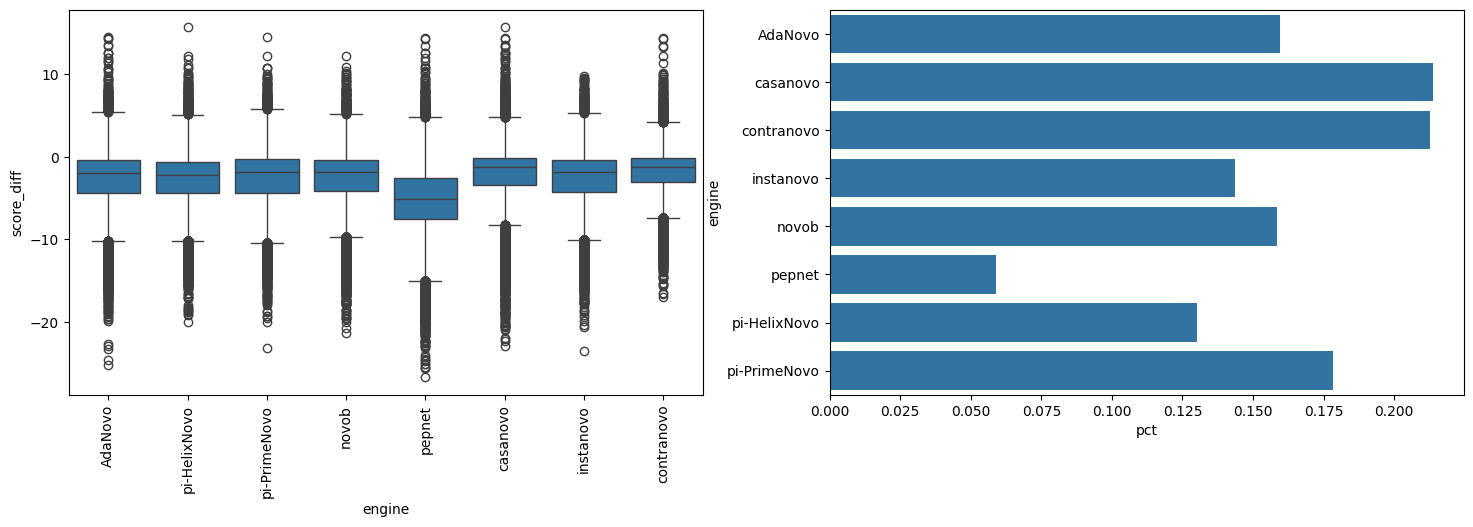

In [154]:
fig, ax = plt.subplots(1,2, figsize=(18,5))

sns.boxplot(
    selection,
    y='score_diff',
    x='engine',
    ax=ax[0]
)
ax[0].tick_params(axis="x", labelrotation=90) 

sns.barplot(
    counts[counts['Higher-scoring']],
    y='engine',
    x='pct',
    ax=ax[1]
)

In [99]:
selection.shape

(803650, 6)

# 3. Load the features under investigation

In [89]:
engine_mapper = {
    'AdaNovo': 'adanovo',
    'pi-HelixNovo': 'pihelixnovo',
    'pi-PrimeNovo': 'piprimenovo',
    'casanovo': 'casanovo',
    'pepnet': 'pepnet',
    'instanovo': 'instanovo',
    'novob': 'novob',
    'contranovo': 'contranovo',
    'DB': 'ground_truth'
}

engine_mapper_reverse = {
    v:k for k, v in engine_mapper.items()
}

feature_names = [
    # Intensity pattern
    'cos',
    'spec_pearson',
    # Retention time
    'rt_diff',
    'rt_diff_best',
    # Matching peaks
    'hyperscore',
    # PPM
    'ppm_precursor',
    'ppm_mean_all',
    # Matching intensity
    'explained_all_pct',
    'explained_b_pct',
    'explained_by_pct',
    'explained_nl_pct',
    'explained_y_pct'
]

def get_features(root, run_names, feature_names, filenames):
    features_list = []
    
    for run_name in run_names:
        print(run_name)
        path = os.path.join(root, run_name, 'features')
        for e in tqdm(filenames):
            path = os.path.join(root, run_name, 'features', e+'.parquet')
            features = load_features(path)

            # parse feature dictionary

            f_df = pd.DataFrame(features).T.reset_index().rename(columns={'index': 'spectrum_id', 1: 'features'})
            f_df['features'] = f_df['features'].apply(lambda x: {k:v for k, v in x.items() if k in feature_names})
            f_df = pd.concat(
                [f_df['spectrum_id'], pd.DataFrame(f_df['features'].tolist())],
                axis=1
            )
            f_df['run'] = run_name
            f_df['engine'] = e
            features_list.append(f_df)

    return pd.concat(features_list, ignore_index=True)

In [ ]:
features_list = get_features(
    root=root_results_dn,
    run_names=run_names,
    feature_names=feature_names
)

In [70]:
features_list_db = get_features(
    root=root_results_dn,
    run_names=run_names,
    feature_names=feature_names,
    filenames=['ground_truth']
)

LFQ_Orbitrap_DDA_Ecoli_01


100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


LFQ_Orbitrap_DDA_Human_01


100%|██████████| 1/1 [00:25<00:00, 25.69s/it]


LFQ_Orbitrap_DDA_QC_01


100%|██████████| 1/1 [00:23<00:00, 23.96s/it]


LFQ_Orbitrap_DDA_Yeast_01


100%|██████████| 1/1 [00:19<00:00, 19.20s/it]


In [ ]:
features_df = pd.concat(
    [features_list, features_list_db],
    axis=0,
    ignore_index=True
)

features_df['engine'] = features_df.engine.apply(
    lambda x: engine_mapper_reverse[x]
)

merged = score_df.merge(
    features_df,
    on=['run', 'spectrum_id', 'engine']
)

print(f'shapes: {features_df.shape} (features), {score_df.shape} (results), {merged.shape} (merged)')

merged_selection = merged[merged['match_type'] != 'match']

In [66]:
features_list.columns

Index(['spectrum_id', 'cos', 'explained_all_pct', 'explained_b_pct',
       'explained_by_pct', 'explained_nl_pct', 'explained_y_pct', 'hyperscore',
       'ppm_mean_all', 'ppm_precursor', 'rt_diff', 'rt_diff_best',
       'spec_pearson', 'run', 'engine'],
      dtype='object')

# 4. Create feature distribution plots

In [97]:
merged_selection.shape

(989751, 18)

In [148]:
def plot_feature_distributions(
    df,
    feature_name,
    engine_names
):

    fig, ax = plt.subplots(2, 8, sharex=True, sharey=True, figsize=(15,8))

    plt.suptitle(feature_name)
    for i, engine in tqdm(enumerate(engine_names)):
        filtered = df[
            (df['engine'].isin([engine, 'DB']))
        ]

        # Higher scoring spectra
        filtered_higher = filtered[
            (filtered['score_diff'] > 0) |
            (filtered['engine'] == 'DB')
        ]
        counts_higher = filtered_higher[['run', 'spectrum_id']].value_counts().to_dict()
        filtered_higher = filtered_higher[
            filtered_higher.apply(lambda x: counts_higher[(x['run'], x['spectrum_id'])]==2, axis=1)
        ]

        # Lower scoring spectra
        filtered_lower = filtered[
            (filtered['score_diff'] < 0) |
            (filtered['engine'] == 'DB')
        ]
        counts_lower = filtered_lower[['run', 'spectrum_id']].value_counts().to_dict()
        filtered_lower = filtered_lower[
            filtered_lower.apply(lambda x: counts_lower[(x['run'], x['spectrum_id'])]==2, axis=1)
        ]
        sns.kdeplot(
            filtered_higher,
            x=feature_name,
            hue='engine',
            ax=ax[0, i],
            legend=False,
        )
        sns.kdeplot(
            filtered_lower,
            x=feature_name,
            hue='engine',
            ax=ax[1, i],
            legend=False
        )
        ax[0, i].set_title(f'{engine}', fontsize=10)
    plt.show()

In [150]:
feature_name = 'rt_diff_best'
e = [
    'AdaNovo',
    'pi-HelixNovo',
    'pi-PrimeNovo',
    'casanovo',
    'pepnet',
    'instanovo',
    'novob',
    'contranovo'
]

8it [00:30,  3.81s/it]


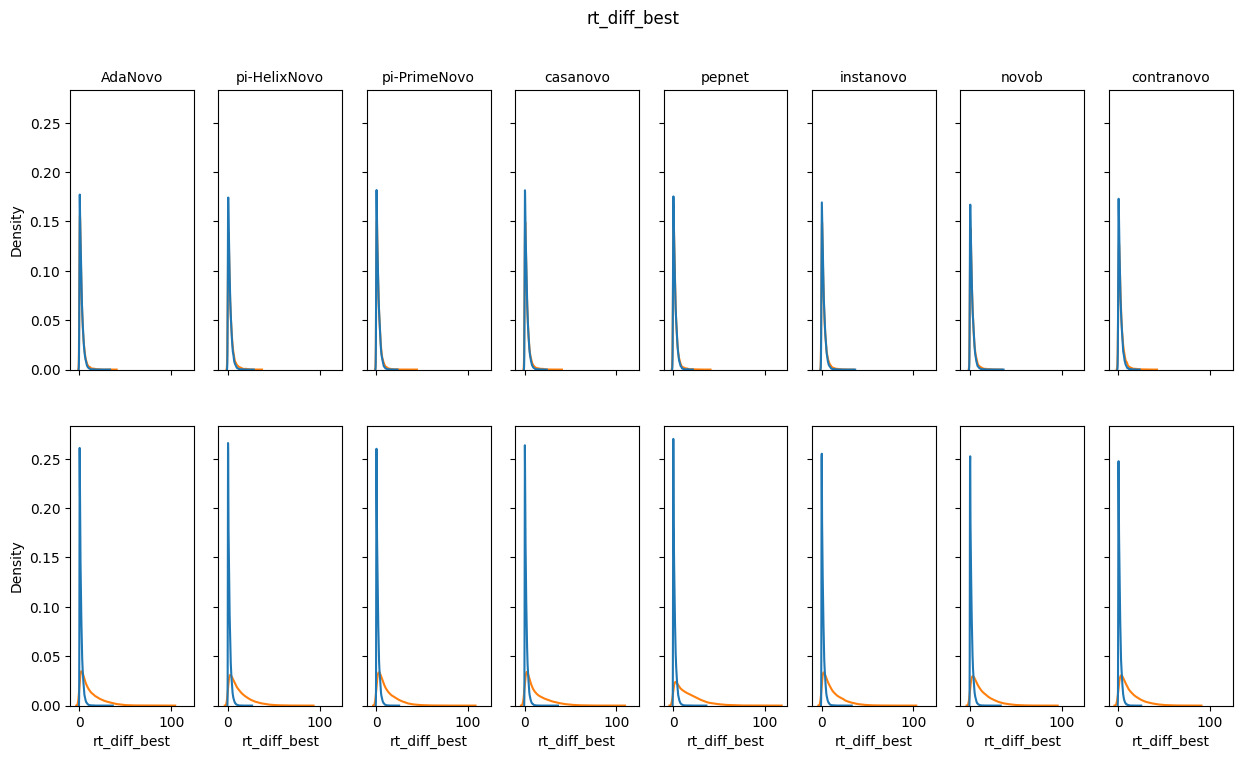

8it [00:30,  3.77s/it]


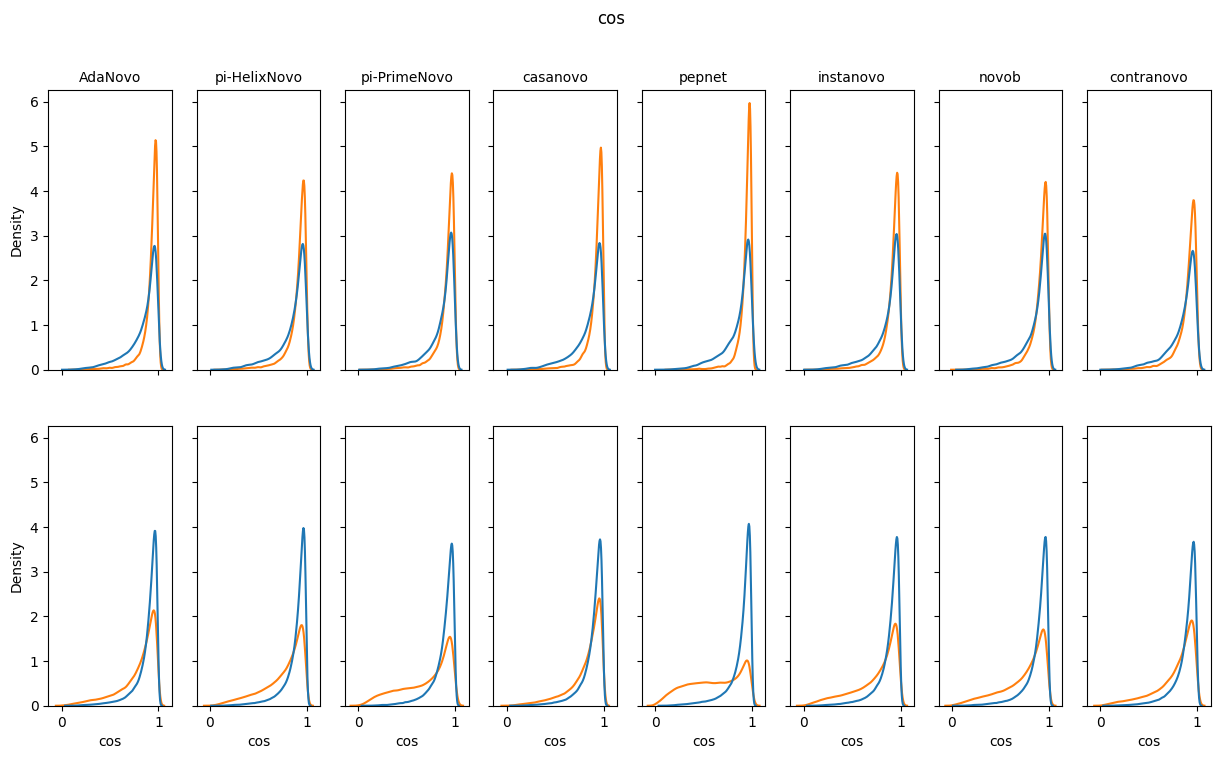

8it [00:30,  3.75s/it]


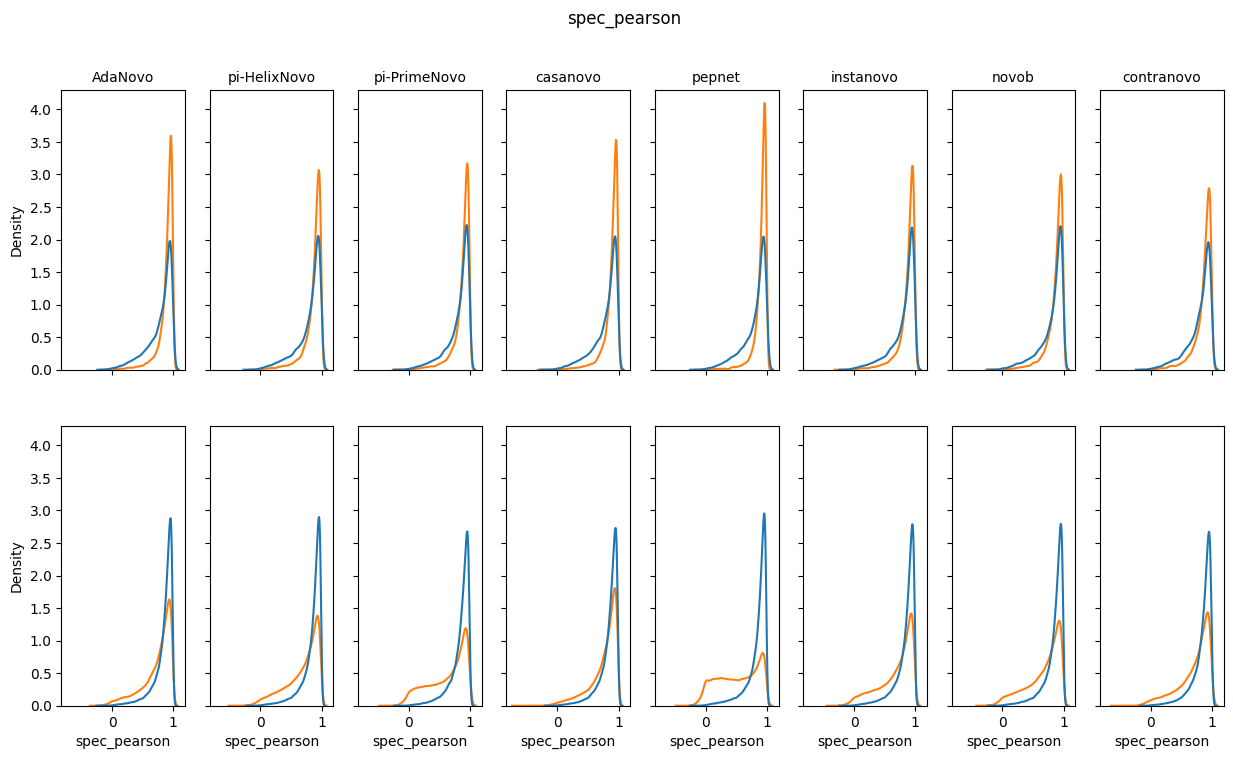

8it [00:30,  3.77s/it]


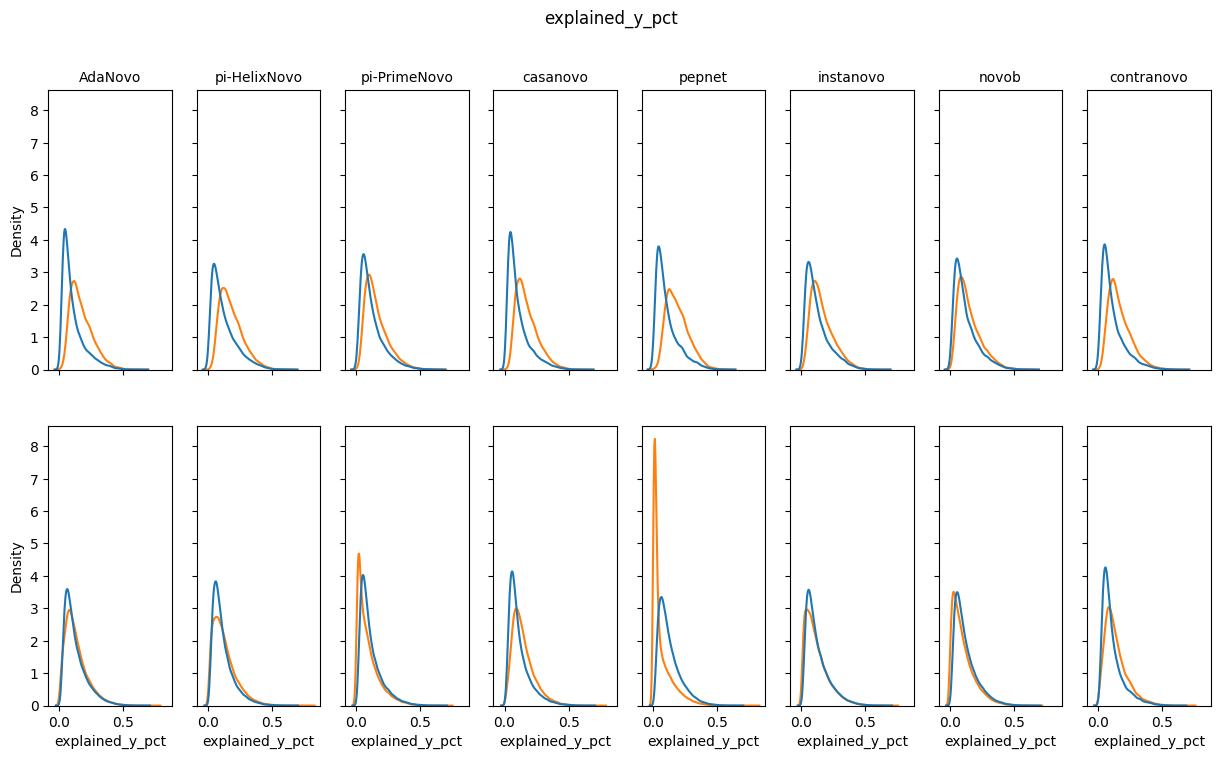

8it [00:54,  6.87s/it]


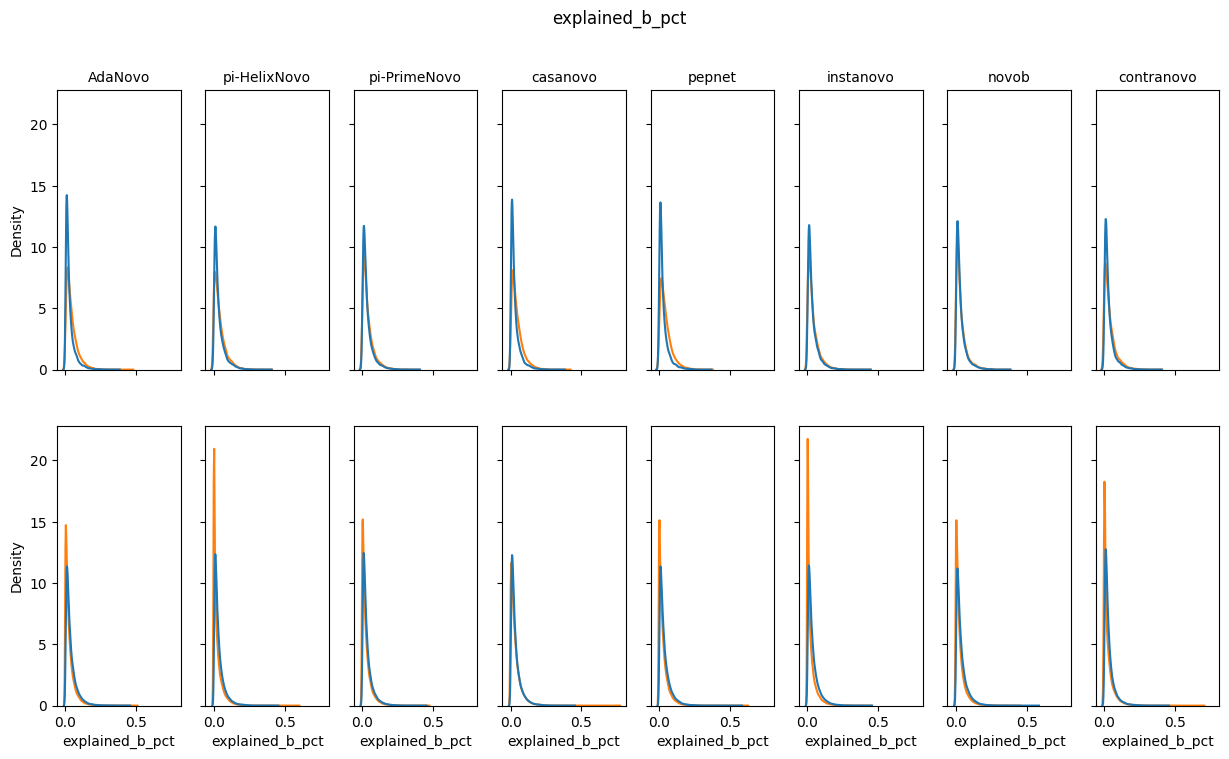

8it [00:30,  3.82s/it]


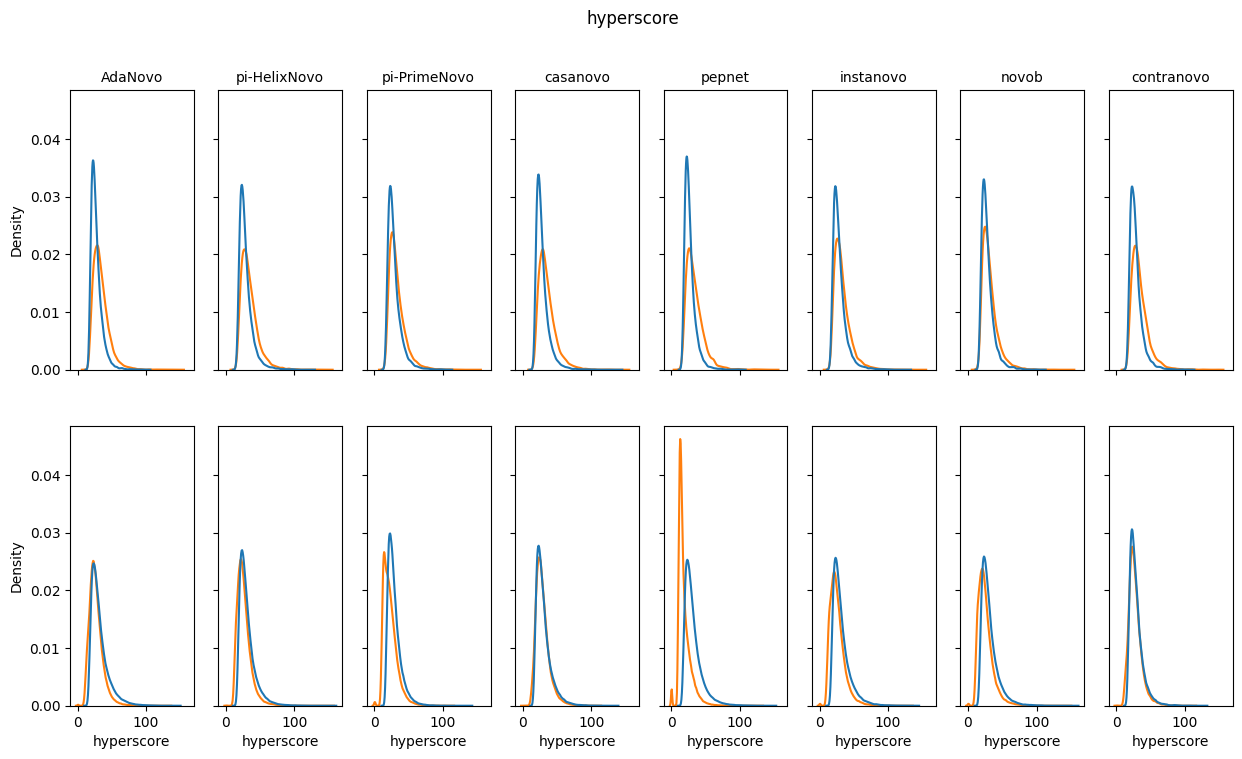

8it [00:29,  3.74s/it]


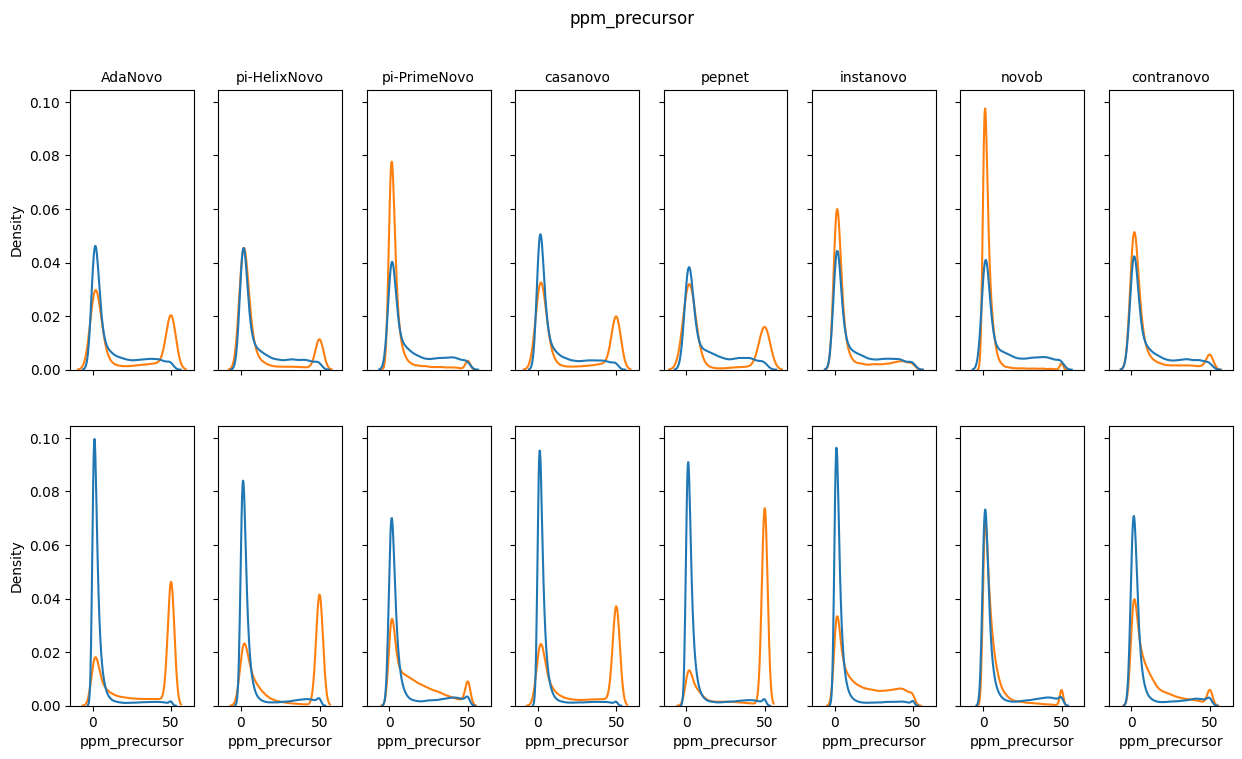

In [151]:
for feature_name in [
    'rt_diff_best',
    'cos',
    'spec_pearson',
    'explained_y_pct',
    'explained_b_pct',
    'hyperscore',
    'ppm_precursor'
]:
    plot_feature_distributions(
        df=merged_selection,
        feature_name=feature_name,
        engine_names=e
    )